"**This set of codes looks at developing a recommender algorithm based on content based filtering. We evaluate the similarity of items by calculating their cosine similarity score from the Term Frequency Inverse Document Frequency.**

In [1]:
import nltk
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
from textblob import TextBlob
import re
from spellchecker import SpellChecker
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import warnings
import timeit
import os
import random
import pickle

In [2]:
if not sys.warnoptions:
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth',-1)

## 1. Import Processed Anime Data

In [3]:
df = pd.read_csv("processed_data/processed_anime.csv")
print('Data has {} rows and {} columns'.format(df.shape[0], df.shape[1]))

Data has 4808 rows and 92 columns


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4808 entries, 0 to 4807
Data columns (total 92 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                4808 non-null   int64  
 1   Unnamed: 0           4808 non-null   int64  
 2   Unnamed: 0.1         4808 non-null   int64  
 3   Title                4808 non-null   object 
 4   URL                  4808 non-null   object 
 5   English              2862 non-null   object 
 6   Synonyms             3075 non-null   object 
 7   Japanese             4801 non-null   object 
 8   Type                 4808 non-null   object 
 9   Episodes             4585 non-null   float64
 10  Status               4808 non-null   object 
 11  Aired                4808 non-null   object 
 12  Premiered            4808 non-null   object 
 13  Broadcast            4808 non-null   object 
 14  Producers            4808 non-null   object 
 15  Licensors            4808 non-null   o

In [5]:
# check number of animes with missing synopsis\n",
df['Synopsis'].isnull().sum()

0

In [6]:
df[df['Character'].notnull()][['Synopsis','Character']].sample(5)

,Synopsis,Character
4604,Mameushi-kun follows the farmland adventures of a calf that is as small as a dust speck.,['Mameushi-kun no Koutsuu Anzen']
1889,"Shiki Toono sustained a life threatening injury as a child, and due to that incident he was sent away from the Toono household and was given to a relative to be raised. Years later, when Shiki is in high school, the head of the Toono household—his father—dies, and he is ordered to move back in by his sister Akiha, who is the new head of the household. However, Shiki holds a huge secret. Ever since that injury, he has been seeing lines on objects, and only with a special pair of glasses is he able to stop seeing them. Also he is unable to remember anything well from the time before his accident. The day he moves back to the Toono household is the day he stumbles upon a woman named Arcueid Brunstud and decapitates her with one stab of his knife in a temporary fit of insanity. When she suddenly showed up beside him later alive and well, and ask him to be her bodyguard, Shiki's journey to unravel the mysteries of his past begins.",['Carnival Phantasm']
1310,"While exploring ruins on Angel Island, a doctor finds a myserious newborn bird called Kyoro-chan. Together they form a bond and decide to travel the world together. Three years later when the Doctor and Kyoro-chan try to return to Angel Island they become shipwrecked from a storm. Kyoro-chan was able to make it safely to the island but the Doctor was nowhere to be found. Kyoro-chan prays for his safety and hope he returns as he now starts his new life on Angel Island.",['Uchuu Shounen Soran']
3278,"Super Sonico is a clutzy, adorable, and well-endowed 18-year old girl. She's a complete sucker for anything cute, especially stray cats, all of which she giddily adopts. However, though Sonico should be enjoying a carefree and simple lifestyle as a young college student, her life is really anything but easy: she must balance being a professional model, working part-time at her grandmother's restaurant, and practicing guitar and performing concerts with her friends Suzu Fujimi and Fuuri Watanuki in their band, First Astronomical Velocity—all while attending college. SoniAni: Super Sonico the Animation follows Sonico as she faces daunting challenges in her search for her place in the world, even when her days are brimming with love and happiness.",['Mahou Shoujo Sonico★Magica']
2528,"Maeda has just moved into his new apartment to live by himself. While unpacking, a cute middle school student named Chie Satonaka suddenly appears in his room. She introduces herself as his new landlord, which pleasantly surprises him as he has never seen a landlord so young. His excitement is boosted further when the gorgeous Reiko Shirai, who lives directly next to him, also introduces herself as his new neighbor.\n\nOoyasan wa Shishunki! follows the everyday lives of Maeda and his newfound acquaintances, where each day presents itself as an opportunity for new events to unfold and new bonds to be forged.",['Komori-san wa Kotowarenai!']


In [7]:
# duplicate Synopsis column for text preprocessing
df['original_synopsis'] = df['Synopsis']
df.shape

(4808, 93)

In [8]:
# duplicate dataset
df_n = df.copy()

## 2. Text Visualisation

In [9]:
# function to construct word cloud

def word_cloud_text(text):
    clean_text = text.str.cat(sep=' ')
    wordcloud = WordCloud(background_color='white').generate(clean_text)
    
    # display word cloud
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Most Frequent Words")
    plt.show()

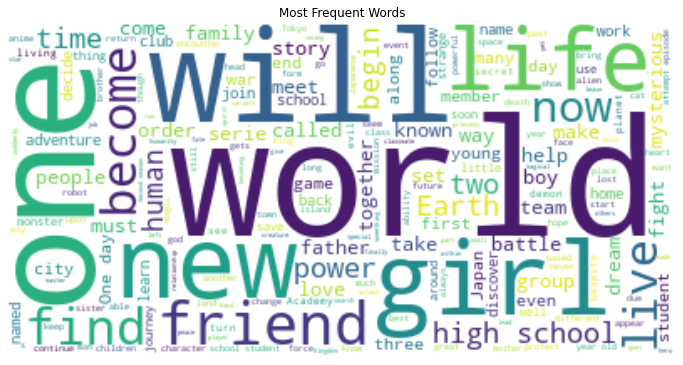

In [10]:
word_cloud_text(df_n['Synopsis'])

**Select some synopsis for viewing**

In [11]:
print('Analyzing 123th record')
print(df_n['Synopsis'][123])
tokenizer = TreebankWordTokenizer()
tokenized_words = tokenizer.tokenize(df_n['Synopsis'][123])
print('\nTokenized Words:\n', tokenized_words)

Analyzing 123th record
With the promise of granting any wish, the omnipotent Holy Grail triggered three wars in the past, each too cruel and fierce to leave a victor. In spite of that, the wealthy Einzbern family is confident that the Fourth Holy Grail War will be different; namely, with a vessel of the Holy Grail now in their grasp. Solely for this reason, the much hated "Magus Killer" Kiritsugu Emiya is hired by the Einzberns, with marriage to their only daughter Irisviel as binding contract.

Kiritsugu now stands at the center of a cutthroat game of survival, facing off against six other participants, each armed with an ancient familiar, and fueled by unique desires and ideals. Accompanied by his own familiar, Saber, the notorious mercenary soon finds his greatest opponent in Kirei Kotomine, a priest who seeks salvation from the emptiness within himself in pursuit of Kiritsugu.

Based on the light novel written by Gen Urobuchi, Fate/Zero depicts the events of the Fourth Holy Grail W

In [12]:
print('Analyzing 500th record')
print(df_n['Synopsis'][500])
tokenizer = TreebankWordTokenizer()
tokenized_words = tokenizer.tokenize(df_n['Synopsis'][500])
print('\nTokenized Words:\n', tokenized_words)

Analyzing 500th record
Having narrowly avoided the collision with the asteroid, the Sidonia sets a course for the Lem system in order to wipe out the Gauna nest.

Tokenized Words:
 ['Having', 'narrowly', 'avoided', 'the', 'collision', 'with', 'the', 'asteroid', ',', 'the', 'Sidonia', 'sets', 'a', 'course', 'for', 'the', 'Lem', 'system', 'in', 'order', 'to', 'wipe', 'out', 'the', 'Gauna', 'nest', '.']


In [13]:
print('Analyzing 1935th record')
print(df_n['Synopsis'][1935])
tokenizer = TreebankWordTokenizer()
tokenized_words = tokenizer.tokenize(df_n['Synopsis'][1935])
print('\nTokenized Words:\n', tokenized_words)

Analyzing 1935th record
Second season.

Tokenized Words:
 ['Second', 'season', '.']


**Observations:**  
1. Character names are present in many of the synopsis  
2. When clearing punctuations, have to be mindful not clear away "-" since they can affect the meaning of the word. E.g. good-for-nothing" vs "good for nothing".  
3. Some description only has words like "second season". For such cases, we would want to concatenate it with its title.

## 3. Text Preprocessing

a. add title to synopsis if synopsis only contains words like "second season"   
b. convert text to lower case & remove punctuations  
c. remove digit, whitespace  
d. remove stopwords  
e. remove words with character length less than or equal to 2  
f. lemmatize words  

In [14]:
# create folder to store processed text
try:
    os.mkdir('./processed_data/tfidf/')
except OSError:
    pass

**Phase I:**  
a. add title to synopsis if synopsis only contains words like "second season"   

In [15]:
df_n['Synopsis'] = np.where(df_n['Synopsis']=='Second season.', df_n['Synopsis'].astype(str) + ' ' + df_n['Title'].astype(str), df_n['Synopsis'].astype(str))

In [16]:
# check if those meaningless synopsis has been corrected
df_n[df_n.index==1976]['Synopsis']

1976    Second season. Ginga Tetsudou Monogatari: Eien e no Bunkiten
Name: Synopsis, dtype: object

In [17]:
# check if those meaningless synopsis has been corrected
df_n[df_n.index==1935]['Synopsis']

1935    Second season. Recorder to Randoseru Re♪
Name: Synopsis, dtype: object

**Phase II:**    
b. convert text to lower case & remove punctuations  
c. remove digit, whitespace  
d. remove stopwords   
e. remove words with character length less than or equal to 2   
f. lemmatization

In [18]:
# create function to convert text to lower case and remove punctuations

def lower_case_remove_punc(text):
    
    lower_text = text.lower()
    remove_punctuations = re.sub('[^\w\s\-]', ' ', lower_text)
    
    return remove_punctuations

In [19]:
# create function to remove digits, whitespace and words with character length <= 2

def remove_digit_ws(text):
    
    remove_digit = re.sub(r'\d+', ' ',text)
    remove_ws = re.sub(r'\s+', ' ', remove_digit)    
    remove_underscore = re.sub(r'_', '', remove_ws)
    
    return remove_underscore

In [20]:
# create function to remove stopwords from nltk library

def remove_stopwords_nltk(text):
    
    stop = stopwords.words('english')
    stopwords_remove = ' '.join(w for w in text.split() if w not in stop)
    
    return stopwords_remove

In [21]:
# create function to remove words with len <=2 as they are likely to be noise

def remove_length_less2(text):
    
    remove_noise = ' '.join(w for w in text.split() if len(w)>2)
    
    return remove_noise

In [22]:
# create function to find pos_tag

def find_pos(word):
    
    # part of speech constants
    # ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
    
    pos = nltk.pos_tag(nltk.word_tokenize(word))[0][1]
    
    if pos.lower()[0] =='j':         # adjectives tags
        return 'a'
    elif pos.lower()[0] =='r':       # Adverb tags
        return 'r'
    elif pos.lower()[0] =='v':       # verb tags
        return 'v'
    else:
        return 'n'                   # Noun tags

In [23]:
# create function to lemmatize word with pos_tag assigned

def words_lemmatizer(text, encoding = 'utf-8'):
    words = nltk.word_tokenize(text)
    lemma_words = []
    wl = WordNetLemmatizer()
   
    for word in words:
        pos = find_pos(word)
        lemma_words.append(wl.lemmatize(word, pos))
        
    return " ".join(lemma_words)

In [24]:
def do_processing_p1(text):

    text_n = lower_case_remove_punc(text)
    text_n = remove_digit_ws(text_n)
    text_n = remove_stopwords_nltk(text_n)
    text_n = remove_length_less2(text_n)
    text_n = words_lemmatizer(text_n)
    return text_n

In [25]:
# Do phase 2 processing
start_time = timeit.default_timer()
df_n['Synopsis'] = df_n['Synopsis'].apply(do_processing_p1)
df_n['Synopsis'].head()
elapsed = timeit.default_timer() - start_time
print('\ntime taken to perform phase 2 processing', elapsed)


time taken to perform phase 2 processing 137.7516664


In [26]:
# output phase 2 processing\n",
df_n.to_csv('./processed_data/tfidf/processed_p2.csv', index=False)

## 4. Generate TFIDF Features from Synopsis to Compute Cosine Similarity of Animes

In [27]:
df_n = pd.read_csv('./processed_data/tfidf/processed_p2.csv')
df_n.shape

(4808, 93)

In [28]:
# examine the data after text preprocessing
df_n[['Synopsis', 'original_synopsis']].head(3)

,Synopsis,original_synopsis
0,order something obtain something equal value must lose alchemy bound law equivalent exchange something young brother edward alphonse elric realize attempt human transmutation one forbidden act alchemy pay terrible price transgression edward loses left leg alphonse physical body desperate sacrifice edward right arm able affix alphonse soul suit armor devastate alone hope would eventually return original body give edward inspiration obtain metal limb call automail become state alchemist fullmetal alchemist three year search later brother seek philosopher stone mythical relic allows alchemist overcome law equivalent exchange even military ally colonel roy mustang lieutenant riza hawkeye lieutenant colonel maes hughes side brother find caught nationwide conspiracy lead true nature elusive philosopher stone country murky history well find serial killer race time edward alphonse must ask make human take away humanity,"""In order for something to be obtained, something of equal value must be lost.""\n\nAlchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail"" and become a state alchemist, the Fullmetal Alchemist.\n\nThree years of searching later, the brothers seek the Philosopher's Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenant Colonel Maes Hughes on their side, the brothers find themselves caught up in a nationwide conspiracy that leads them not only to the true nature of the elusive Philosopher's Stone, but their country's murky history as well. In between finding a serial killer and racing against time, Edward and Alphonse must ask themselves if what they are doing will make them human again... or take away their humanity."
1,gabi braun falco grice training entire life inherit one seven titan marley control aid nation eradicate eldians paradis however seem well two cadet peace suddenly shaken arrival eren yeager remain member survey corp finally reach yeager family basement learn dark history surround titan survey corp long last found answer desperately fought uncover truth hand group set world beyond wall shingeki kyojin final season two utterly different world collide party pursues agenda long-awaited conclusion paradis fight freedom,"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. \n\nHaving finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls.\n\nIn Shingeki no Kyojin: The Final Season, two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."
2,self-proclaimed mad scientist rintarou okabe rent room rickety old building akihabara indulges hobby invent prospective future gadget fellow lab member mayuri shiina air-headed childhood friend hashida itaru pervert hacker nickname daru three pas time tinker promising contraption yet machine dubbed phone microwav

In [29]:
# check if any of the synopsis is null after text preprocessing
df_n['Synopsis'].isnull().sum()

0

In [30]:
# create tfidf vectorizer
vec = TfidfVectorizer(analyzer='word', ngram_range=(1,5))
anime_mat = vec.fit_transform(df_n['Synopsis'])

In [31]:
# calculate the cosine similarity between each anime and all other animes
# takes awhile to run ~ 15 mins
from sklearn import metrics

anime_similarity = []
for idx in range(anime_mat.shape[0]):
    similarity = metrics.pairwise.linear_kernel(anime_mat[idx, :], anime_mat).flatten()
    anime_similarity.append(similarity)

In [32]:
# convert the results to a DataFrame
# takes awhile to gen,
anime_list = df_n['anime_uid']
anime_similarity = pd.DataFrame(anime_similarity, index=anime_list, columns=anime_list)
anime_similarity

anime_uid,5114,40028,9253,38524,28977,11061,9969,15417,35180,34096,...,42590,39473,41812,33737,42340,31445,43778,35335,39893,40608
anime_uid,,,,,,,,,,,,,,,,,,,,,
5114,1.000000,0.001224,0.002319,0.004575,0.002021,0.002468,0.003199,0.002227,0.001763,0.001291,...,0.002241,0.001162,0.002446,0.002559,0.003441,0.000000,0.000000,0.000000,0.000724,0.007893
40028,0.001224,1.000000,0.001608,0.069121,0.003331,0.004879,0.002956,0.003516,0.002756,0.003139,...,0.001769,0.003676,0.002057,0.000615,0.002808,0.000000,0.000000,0.000000,0.001441,0.000000
9253,0.002319,0.001608,1.000000,0.001623,0.003176,0.001965,0.003162,0.001267,0.002251,0.002476,...,0.000349,0.002133,0.001693,0.003850,0.000000,0.000849,0.000000,0.000000,0.000000,0.002369
38524,0.004575,0.069121,0.001623,1.000000,0.001955,0.003042,0.002539,0.003526,0.001107,0.001541,...,0.001198,0.000000,0.001128,0.001906,0.000428,0.000000,0.000000,0.000000,0.000964,0.002945
28977,0.002021,0.003331,0.003176,0.001955,1.000000,0.002751,0.061650,0.054896,0.002285,0.034797,...,0.002157,0.001383,0.000734,0.000000,0.003320,0.000826,0.000000,0.003795,0.003227,0.000586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31445,0.000000,0.000000,0.000849,0.000000,0.000826,0.002348,0.001369,0.001463,0.002859,0.001699,...,0.001431,0.000778,0.000000,0.002695,0.003033,1.000000,0.000000,0.006093,0.013526,0.000000
43778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.025532,0.000000,0.000000
35335,0.000000,0.000000,0.000000,0.000000,0.003795,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.003154,0.000000,0.006093,0.025532,1.000000,0.000000,0.000000


In [33]:
# output the anime similarity dataframe to csv
anime_similarity.to_csv('processed_data/tfidf/anime_similarity.csv')

## 5. Examine the Similar Animes Found

In [34]:
# for each anime, extract the corresponding top 11 similar animes (top 11 is because itself is also included)
nlargest = 11
order = np.argsort(-anime_similarity.values, axis=1)[:, :nlargest]
result = pd.DataFrame(anime_similarity.columns[order], 
                      columns=['top{}'.format(i) for i in range(1, nlargest+1)],
                      index=anime_similarity.index)

In [35]:
# check result dataframe
result.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,top11
anime_uid,,,,,,,,,,,
5114,5114,121,2215,31405,40852,21167,40934,4574,1878,1065,2806
40028,40028,25777,38524,35760,16498,32419,31374,40087,42938,85,40964
9253,9253,30484,4181,545,19997,1128,2024,6974,3915,27521,13599
38524,38524,25777,40028,16498,35760,31374,85,6448,5829,5973,37798
28977,28977,9969,15417,35843,34096,918,10513,36838,33099,26395,36981


In [36]:
# for each anime, extract the corresponding cosine similarity score for the top 11 similar animes
top11_cos_sim = []
for i in range(len(anime_similarity)):
    x = anime_similarity.values[i][order[i]].tolist()
    top11_cos_sim.append(x)
    
# convert to df
cos_sim_results = pd.DataFrame(top11_cos_sim,
                              columns=['top{}_cosim'.format(i) for i in range(1, nlargest+1)],
                              index=anime_similarity.index)

In [37]:
# combine the two df together
cosim_results = pd.concat([result, cos_sim_results], axis=1)

In [38]:
# print cosim results
cosim_results

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,...,top2_cosim,top3_cosim,top4_cosim,top5_cosim,top6_cosim,top7_cosim,top8_cosim,top9_cosim,top10_cosim,top11_cosim
anime_uid,,,,,,,,,,,,,,,,,,,,,
5114,5114,121,2215,31405,40852,21167,40934,4574,1878,1065,...,0.133106,0.017749,0.017549,0.017222,0.014717,0.013844,0.012502,0.012303,0.011857,0.011473
40028,40028,25777,38524,35760,16498,32419,31374,40087,42938,85,...,0.076523,0.069121,0.051226,0.040411,0.033152,0.032195,0.024558,0.024083,0.018215,0.012144
9253,9253,30484,4181,545,19997,1128,2024,6974,3915,27521,...,0.075325,0.011531,0.011099,0.010959,0.010463,0.009862,0.009686,0.009261,0.009064,0.008837
38524,38524,25777,40028,16498,35760,31374,85,6448,5829,5973,...,0.087443,0.069121,0.054455,0.054069,0.047438,0.016227,0.012767,0.012627,0.010835,0.010649
28977,28977,9969,15417,35843,34096,918,10513,36838,33099,26395,...,0.061650,0.054896,0.047055,0.034797,0.027256,0.023469,0.023010,0.018703,0.018587,0.017835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31445,21427,31445,47160,17687,5854,960,20087,36740,21033,31893,...,1.000000,0.036897,0.034378,0.032982,0.032982,0.025596,0.022969,0.020629,0.019817,0.019779
43778,43778,3638,5089,18241,2741,3264,6482,8521,40166,42090,...,0.071981,0.058361,0.049488,0.044646,0.042741,0.042265,0.041571,0.041415,0.038973,0.038742
35335,35335,35303,5089,36265,8521,18241,40671,27927,2741,3264,...,0.087122,0.073042,0.070739,0.070471,0.061936,0.060621,0.057115,0.055877,0.053493,0.052897


In [39]:
# examine the max top2_cosim score
print('Max Cosine Similarity Score across all animes:{}'.format(max(cosim_results['top2_cosim'])))

Max Cosine Similarity Score across all animes:1.0000000000000047


<AxesSubplot:>

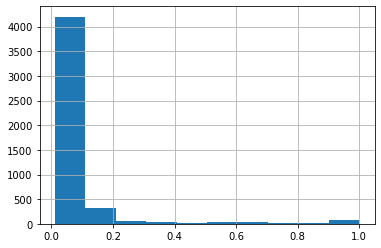

In [40]:
# examine the distribution of the max top2_cosim score
cosim_results['top2_cosim'].hist(bins=10)

In [41]:
cosim_results['top2_cosim'].describe()

count    4808.000000
mean     0.082549   
std      0.150740   
min      0.011410   
25%      0.027170   
50%      0.039913   
75%      0.068399   
max      1.000000   
Name: top2_cosim, dtype: float64

**Observation**  
1. The similarity score is very low, with similarity score even at 75th Percentile being 0.06889
2. Strangely, we observed similarity score = 1

In [42]:
# extract records where top2_cosim = 1 --> ambiguous
ambiguous = cosim_results[cosim_results['top2_cosim']>=1]

In [43]:
# examine the synopsis of these cases with cosine similarity score = 1
animes_id_examine = set(ambiguous['top1'].tolist() + ambiguous['top2'].tolist() + ambiguous['top3'].tolist())
len(animes_id_examine)
df_n[(df_n['anime_uid'].isin(animes_id_examine))][['anime_uid', 'Title', 'Synopsis', 'original_synopsis', 'Type']]


,anime_uid,Title,Synopsis,original_synopsis,Type
9,34096,Gintama.,join resistance bakufu gintoki gang hiding along katsura joui rebel yorozuya soon approach nobume imai two member kiheitai explain harusame pirate turn division captain kamui former ally takasugi kiheitai present gintoki job find takasugi miss since ship ambush harusame raid nobume also make stun revelation regard tendoushuu secret organization pull string numerous faction leader utsuro shadowy figure uncanny resemblance gintoki former teacher hitch ride sakamoto space ship yorozuya katsura set rakuyou kagura home planet various faction gather tension brewing long-held grudge political infighting tendoushuu sinister overarch plan finally culminate massive decisive battle rakuyou,"After joining the resistance against the bakufu, Gintoki and the gang are in hiding, along with Katsura and his Joui rebels. The Yorozuya is soon approached by Nobume Imai and two members of the Kiheitai, who explain that the Harusame pirates have turned against 7th Division Captain Kamui and their former ally Takasugi. The Kiheitai present Gintoki with a job: find Takasugi, who has been missing since his ship was ambushed in a Harusame raid. Nobume also makes a stunning revelation regarding the Tendoushuu, a secret organization pulling the strings of numerous factions, and their leader Utsuro, the shadowy figure with an uncanny resemblance to Gintoki's former teacher.\n\nHitching a ride on Sakamoto's space ship, the Yorozuya and Katsura set out for Rakuyou, Kagura's home planet, where the various factions have gathered and tensions are brewing. Long-held grudges, political infighting, and the Tendoushuu's sinister overarching plan finally culminate into a massive, decisive battle on Rakuyou.",TV
280,1471,City Hunter 2,ryo saeba sweeper know city hunter sidekick kaori makimura hire solve problem police handle keep street tokyo clean ryo chase lady kaori chase giant anti-ecchi hammer,"Ryo Saeba is a ""sweeper"" know as the City Hunter. He and his sidekick Kaori Makimura are hired to solve problems that the police can't (or won't) handle. When he's not keeping the streets of Tokyo clean, Ryo is chasing the ladies, and Kaori chases after him with a giant anti-ecchi hammer.",TV
450,1472,City Hunter 3,ryo saeba sweeper know city hunter sidekick kaori makimura hire solve problem police handle keep street tokyo clean ryo chase lady kaori chase giant anti-ecchi hammer,"Ryo Saeba is a ""sweeper"" know as the City Hunter. He and his sidekick Kaori Makimura are hired to solve problems that the police can't (or won't) handle. When he's not keeping the streets of Tokyo clean, Ryo is chasing the ladies, and Kaori chases after him with a giant anti-ecchi hammer.",TV
481,1473,City Hunter '91,ryo saeba back city hunter sweeper private detective work street tokyo sidekick kaori makimura hire solve problem desperate people ryo use sharp shoot skill bad guy aim site pretty lady kaori us giant anti-ecchi hammer make sure behaves,"Ryo Saeba is back as the City Hunter, a ""sweeper"" (private detective) working on the streets of Tokyo. He and sidekick Kaori Makimura are hired to solve the problems of desperate people. When Ryo is not using his sharp shooting skills against bad guys, he's aiming his sites on pretty ladies. Kaori uses a giant anti-ecchi hammer to make sure he behaves.",TV
647,951,Chibi Maruko-chan,momoko sakura elementary school student like popular idol momoe yamaguchi mangas often call chibi maruko-chan due young age small size life together parent grandparent elder sister little town school many friend study play together everyday include close pal tama-chan student committee member maruo-kun migiwa-san b-class trio little master hanawa-kun hamaji-bu taro sekiguchi-kun fun-loving enjoyable anime portrays simple thing life,"Momoko Sakura is an elementary school student who likes popular idol Momoe Yamaguchi and mangas. She is often called ""Chibi Maruko-chan"" due to her young age and small si

**Observations**  
1. The high similarity score is because the animes are series.

## 6. Calculate Prediction Ratings

With the cosine similarity score, we can calculate the predicted rating for every user.  
The steps to do so are summarised below:  
1. Split reviews data into train and test data  
2. For every user in the train dataset, we identify the animes which have been watched by the user and animes which have not been watched by the user. We used rating as a proxy of whether user had watched the anime. 
3. Thereafter, we compute the predicted rating for Item i for User by applying the formula:  
$\hat{P}_{u,i} = \frac {\sum \limits _{m \in I} (r_{u,m} * s_{i,m})} {\sum \limits _{m \in I} s_{i,m}}  $  
4. Based on the predicted ratings, we identify Top 10 items to be recommended to user and compute the hit rate by comparing it against the test dataset.


**import dataset**

In [44]:
df_review = pd.read_csv('processed_data/processed_reviews.csv')
df_review.shape

(75921, 7)

In [45]:
df_review.columns

Index(['uid', 'profile', 'anime_uid', 'text', 'score', 'scores', 'link'], dtype='object')

In [46]:
# check the distribution of ratings
df_review['score'].describe()

count    75921.000000
mean     7.353038    
std      2.219829    
min      0.000000    
25%      6.000000    
50%      8.000000    
75%      9.000000    
max      10.000000   
Name: score, dtype: float64

**a. Train Test Split**

Apply the leave-one-out methodology to do train-test split. For each user, the most recent review is used as the test set. The most recent review is indicated by the larger uid. The reamining ratings would be used in the train dataset. This will help to ensure no data leakage.

In [47]:
# create test dataset
test = df_review.loc[df_review.groupby('profile')['uid'].idxmax()]
test.shape

(15363, 7)

In [48]:
# create train dataset
train = df_review[~(df_review['uid'].isin(test['uid'].tolist()))]
train.shape

(60558, 7)

**b. Identify animes which have been watched by users as well as those which have not been watched by users**

In [49]:
# create a unique list of anime_uid
anime_uid = list(set(anime_similarity.index.tolist()))
len(anime_uid)

4808

In [50]:
# create a unique list of profiles from train dataset
profile_list = list(set(train['profile'].tolist()))
len(profile_list)

15363

In [51]:
# identify list of animes watched 
# identify the list of animes not watched. As the not watched list is huge, 
# we randomly sample 99 animes not watched items + the one watched item in the test data to form the not watched list.
# we repeat this random sampling 10 times to ensure robustness while accounting for limited computational resource.

watched_list = []
not_watched_list_1 = []
not_watched_list_2 = []
not_watched_list_3 = []
not_watched_list_4 = []
not_watched_list_5 = []

for user in profile_list:
    
    # subset watched animes - i.e. those with ratings
    u_watched = train[train['profile']==user]['anime_uid'].tolist()
    watched_list.append(u_watched)
    
    # identify animes not watched i.e. those without ratings
    u_not_watched = list(set(anime_uid) - set(u_watched) - set(test[test['profile']==user]['anime_uid'].tolist()))
    
    # set seed to control reproducibility of sampling
    random.seed(2345)
    u_not_watched_1 = random.sample(u_not_watched, 99) + test[test['profile']==user]['anime_uid'].tolist()
    not_watched_list_1.append(u_not_watched_1)
    
    random.seed(2346)
    u_not_watched_2 = random.sample(u_not_watched, 99) + test[test['profile']==user]['anime_uid'].tolist()
    not_watched_list_2.append(u_not_watched_2)
    
    random.seed(2347)
    u_not_watched_3 = random.sample(u_not_watched, 99) + test[test['profile']==user]['anime_uid'].tolist()
    not_watched_list_3.append(u_not_watched_3)
    
    random.seed(2348)
    u_not_watched_4 = random.sample(u_not_watched, 99) + test[test['profile']==user]['anime_uid'].tolist()
    not_watched_list_4.append(u_not_watched_4)
    
    random.seed(2349)
    u_not_watched_5 = random.sample(u_not_watched, 99) + test[test['profile']==user]['anime_uid'].tolist()
    not_watched_list_5.append(u_not_watched_5)


In [52]:
# check len of watched_list and not watched list
print(len(watched_list))
print(len(not_watched_list_1))
print(len(not_watched_list_5))

15363
15363
15363


In [53]:
# check 
print(len(watched_list[0]))
print(len(not_watched_list_1[0]))
print(len(not_watched_list_5[0]))

1
100
100


**c. Compute the predicted ratings for not watched list for each user**

In [54]:
# Create a function to compute the predicted ratings for not watched list for each user

def predict_ratings(profile, not_watched, train_dataset, sim_matrix):
    
    '''
    Args:
        profile - list of unique profiles
        not_watched - list of not watched animes for all users
        train_dataset - train data
        sim_matrix - matrix capturing the cosine similarity between every pair of anime x and anime y
    
    Returns:
        predicted_ratings - nested list of predicted ratings for each user

    '''
    
    # initialise list to store predictions
    predicted_rating = []
    
    for i in range(len(profile)):
        
        # subset the ratings for watched animes
        watched_animes_ratings = train_dataset[train_dataset['profile']==profile[i]][['score', 'anime_uid']].sort_values(by=['anime_uid'])
    
        # initialise list to store ratings for user
        individual_ratings = []
    
        # subset animes not watched for user
        animes = not_watched[i]
        #print(len(animes))
    
        # iterate through every anime not watched
        for k in animes:          
            
            # subset the cosine similarity vector between anime and watched animes
            cos_sim_subset = sim_matrix[k]
            cos_sim_subset = cos_sim_subset[(cos_sim_subset.index.isin(animes)) | 
                                             (cos_sim_subset.index.isin(watched_animes_ratings['anime_uid'].tolist()))]
            total_sim_score = sum(cos_sim_subset)
            cos_sim_subset = cos_sim_subset[cos_sim_subset.index.isin(watched_animes_ratings['anime_uid'].tolist())]
            cos_sim_subset = cos_sim_subset.sort_index(ascending=False)
        
            # compute predicted ratings
            for x, y in zip(cos_sim_subset, watched_animes_ratings['score']):
                predictions = np.sum(np.dot(x,y))/total_sim_score
            
            individual_ratings.append(predictions)
    
        #print(len(individual_ratings))
        predicted_rating.append(individual_ratings)
    
    return predicted_rating


In [55]:
# Generate predict ratings based on the different sets of randomly sampled 100 not watched animes for each user

start_time = timeit.default_timer()

predicted_ratings_1 = predict_ratings(profile_list, not_watched_list_1, train, anime_similarity)
print('done')
predicted_ratings_2 = predict_ratings(profile_list, not_watched_list_2, train, anime_similarity)
print('done')
predicted_ratings_3 = predict_ratings(profile_list, not_watched_list_3, train, anime_similarity)
print('done')
predicted_ratings_4 = predict_ratings(profile_list, not_watched_list_4, train, anime_similarity)
print('done')
predicted_ratings_5 = predict_ratings(profile_list, not_watched_list_5, train, anime_similarity)
print('done')

elapsed = timeit.default_timer() - start_time
print('Time taken:', elapsed)

done
done
done
done
done
Time taken: 3518.2987875999997


**d. Evaluate Hit Rate @ 10 for Proposed Recommender**

In [56]:
# create function to evaluate hit rate @ 10

def hit_rate(predictions, not_watched, test_dataset, profile):
    
    '''
    Args:
        predictions - nested list of predicted ratings of every user for the 100 animes randomly sampled
        not_watched - nested list of 100 animes not watched for each user
        test_dataset - test data
        profile - list of unique profiles
    
    Returns:
        hit_rate - hit rate @ 10
        top_10_animes - nested list of top 10 ainmes recommended for each user 
    '''
    
    top_10_animes = []
    hit = 0
    
    for i in range(len(predictions)):
    
        user = profile[i]
    
        # get the top 10 animes recommended to user
        top_10_idx = np.argsort(predictions[i])[-10:]
        top_10_animes = [not_watched[i][k] for k in top_10_idx]
    
        # check if the test data is found in the proposed top 10 recommended animes
        anime_watched = test_dataset[test_dataset['profile']==user]['anime_uid']

        if anime_watched.values in top_10_animes:
            hit += 1
        else:
            hit = hit
    
    hit_rate = round((hit/len(profile))*100,2)
    
    return top_10_animes, hit_rate

In [57]:
# Generate hit rate @ 10 for the different samples

start_time = timeit.default_timer()

top_10_animes_1, hit_rate_1 = hit_rate(predicted_ratings_1, not_watched_list_1, test, profile_list)
top_10_animes_2, hit_rate_2 = hit_rate(predicted_ratings_2, not_watched_list_2, test, profile_list)
top_10_animes_3, hit_rate_3 = hit_rate(predicted_ratings_3, not_watched_list_3, test, profile_list)
top_10_animes_4, hit_rate_4 = hit_rate(predicted_ratings_4, not_watched_list_4, test, profile_list)
top_10_animes_5, hit_rate_5 = hit_rate(predicted_ratings_5, not_watched_list_5, test, profile_list)

elapsed = timeit.default_timer() - start_time
print('Time taken:', elapsed)


Time taken: 79.77098650000016


In [58]:
# print hit rates
print('Hit Rate @ 10 based on not_watched_list_1: {}%'.format(hit_rate_1))
print('Hit Rate @ 10 based on not_watched_list_2: {}%'.format(hit_rate_2))
print('Hit Rate @ 10 based on not_watched_list_3: {}%'.format(hit_rate_3))
print('Hit Rate @ 10 based on not_watched_list_4: {}%'.format(hit_rate_4))
print('Hit Rate @ 10 based on not_watched_list_5: {}%'.format(hit_rate_5))



Hit Rate @ 10 based on not_watched_list_1: 21.67%
Hit Rate @ 10 based on not_watched_list_2: 20.05%
Hit Rate @ 10 based on not_watched_list_3: 20.5%
Hit Rate @ 10 based on not_watched_list_4: 21.33%
Hit Rate @ 10 based on not_watched_list_5: 20.79%


In [60]:
# print avg hit rates
avg_hit_rate = (hit_rate_1 + hit_rate_2 + hit_rate_3 + hit_rate_4 + hit_rate_5)/5 
print('Average Hit Rate @ 10 based on the 5 different sets of randomly sampled not watched list: {}%'.format(avg_hit_rate))


Average Hit Rate @ 10 based on the 5 different sets of randomly sampled not watched list: 20.868000000000002%


In [62]:
# save the results
hit_rates_all = [hit_rate_1, hit_rate_2, hit_rate_3, hit_rate_4, hit_rate_5, avg_hit_rate]

with open("processed_data/tfidf/model1_results.txt", "wb") as fp:   
    pickle.dump((predicted_ratings_1, predicted_ratings_2, predicted_ratings_3, predicted_ratings_4, predicted_ratings_5, \
                not_watched_list_1, not_watched_list_2, not_watched_list_3, not_watched_list_4, not_watched_list_5, \
                 top_10_animes_1, top_10_animes_2, top_10_animes_3, top_10_animes_4, top_10_animes_5, hit_rates_all, \
                watched_list, profile_list), fp)
